In [49]:
import numpy as np
import pptk
import networkx as nx
import imageio
import glob
import re
from random import sample, seed
from scipy.spatial import distance
from time import strftime
import os
import scipy.optimize as optimize
import math
from sklearn.linear_model import LinearRegression
import time
import copy
from moving_least_square import *
from tempfile import TemporaryFile
from collections import defaultdict
from vpython import *
from math import *
scene = canvas()

<IPython.core.display.Javascript object>

In [50]:
seed(20)
if os.name == 'nt': # Windows
    system_win = 1
else:
    system_win = 0

In [51]:
# Given the data points, return the MST of the point cloud generated from the PNG files and an array 
# of points positions
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#        drawMST: boolean value. Default is false. If set true, the function will also draw a MST graph at the end
#        sampleNumber: int value. Default is 5000. This function will only sample <sampleNumber> points from the data
# Return: a NetworkX graph representing the Minimum spanning tree of the data points
def getMSTFromDataPoint(data, drawMST: bool=False, sampleNumber: int=5000):
    # Read points data from PNGs 
    if(sampleNumber > len(data)):
        sampleNumber = len(data)
        
    # default sample 5000 points from the whole set, otherwise it would take too long
    print("---------------")
    print("There are " + str(len(data)) + " points in total. Now sampleling " + str(sampleNumber) + " points from them")
    sample_data = np.asarray(sample(list(data), sampleNumber))
    print("---------------")
    print("Done!")
    
    #display the points 
    #displayPoints(sample_data, 1.3)
    
    #Create a networkX graph instance that represent MST
    print("---------------")
    print("Begin creating a MST of the sampled points cloud")
    MST = CreateMSTGraph(sample_data)
    print("---------------")
    print("MST creation Done!")
    
    if(drawMST):
        nx.draw(MST, dict(enumerate(sample_data[:, :2])))
        
    return (MST, sample_data)
    

In [52]:
# This function will invoke a pptk viewer to render the points 
# Param: data: an array of points coordinate. Each point's coordinate should has the format of [x, y, z]
#       pointSize: the size of the point to be rendered on the screen
# Return: none

def displayPoints(data, pointSize):
    v = pptk.viewer(data)
    v.set(point_size=pointSize)

In [53]:
# This function will read a txt file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate should has the format of [x, y, z]
# Param: filePath: the file path of the txt file
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def readPointFromTXT(filePath):
    data = np.genfromtxt(fname=filePath, skip_header=0)
    return data

In [54]:
# This function will read a series of PNG file and convert its content to point data, which is an array of points coordinate. 
# Each point's coordinate will have the format of [x, y, z]
# Param: filePath: the file path of the PNG files. Each file should be named as 1.png, 2.png, 3.png ... etc. All the png file should 
#                  be ordered by the their topological order from their original dicom file
#        orientation: 0, 1, or 2. 0 stands for coronal. 1 stands for transverse. 2 stands for sagittal.
# Return: an array of points coordinate. Each point's coordinate has the format of [x, y, z]

def ReadPointFromPNG(filepath, orientation:int, padding:int):
    print("---------------")
    print("Begin reading points data from PNG files")
    path_list = [im_path for im_path in glob.glob(filepath)]
    
    if system_win:
        path_list_parsed = [re.split('\\\\|\.', path) for path in path_list]
    else:
        path_list_parsed = [re.split('/|\.', path) for path in path_list]
    path_list_parsed_valid = [x for x in path_list_parsed if x[-1] == 'png']
    path_list_parsed_valid = sorted(path_list_parsed_valid, key=lambda x:int(x[-2]))
    
    print("There are", len(path_list_parsed_valid),"PNG files, now convert them to point coordinates in 3D")
    imageData = []
    
    for path in path_list_parsed_valid:
        s = ""
        if system_win:
            s = "\\"
        else:
            s = "/"
        s = s.join(path)
        s = s[:-4] + '.png'
        image = imageio.imread(s)
        
        for i in range(padding):
            imageData.append(image)
    
    
    # Transfrom the matrix to list of points' coordinate whose grey scalse is not 0 (colon area)
    if(orientation == 0):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [1, 2, 0]]
        #xyz[:, 2] = xyz[:, 2]*3*thickness
        
    elif(orientation == 1):
        yxz = np.transpose(np.where(imageData))
        xyz = yxz[:, [1, 0, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
        
    elif(orientation == 2):
        zxy = np.transpose(np.where(imageData))
        xyz = zxy[:, [0, 1, 2]]
        #xyz[:, 0] = xyz[:, 0]*3*thickness
    
    else:
        print("Orientation shoud only be one of 0, 1 or 2 only.  0 stands for coronal. \
        1 stands for transverse. 2 stands for sagittal.")
        
    print("Done!")
    return xyz

In [55]:
# This function is used to limited the number of edges in the original graph.
# Instead of creating a graph with full connectivity, this function will return 
# a list of neighbor points for each point and we will only connect them in the graph
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# return: a tuple(closestIndices, closesDis). ClosestIndices is a matrix of each point's neighbors. 
#         closestDis is a matrix of the distances between each point and their neighbors

def getNearbyPoints(pointsData):
    D = distance.squareform(distance.pdist(pointsData))
    closestIndicies = np.argsort(D, axis=1)
    closestDis = np.sort(D, 1)
    threshold = 10 # This number can be changed. The greater this number, the more edges
    return (closestIndicies[:, 1:threshold], closestDis[:, 1:threshold])

In [56]:
# This function converts points' coordinate data into a minimum spanning tree. In this graph, the nodes are the points
# from the points cloud and the edges are the connection between each point and their neighbors. The weights are each 
# connection's distance in space
# Param: pointsData: an array of points coordinate. Each point's coordinate has the format of [x, y, z]
# Return: A networkX instance containing the MST

def CreateMSTGraph(pointsData):
    print("---------------")
    print("Begin calculating nearby points for each point")
    nearbyInfo = getNearbyPoints(pointsData)
    print("---------------")
    print("Nearby points calculation Done!")
    print("---------------")
    print("Begin construct graph")
    G=nx.Graph()
    closestIndicies = nearbyInfo[0]
    closestDis = nearbyInfo[1]
    for firstPIndex in range(len(closestIndicies)):
        for second in range(len(closestIndicies[firstPIndex])):
            secondPIndex = closestIndicies[firstPIndex][second]
            G.add_edge(firstPIndex, secondPIndex , weight = closestDis[firstPIndex][second])
    print("---------------")
    print("Graph construction Done!")
    print("---------------")
    print("Begin calculate MST")
    G = nx.minimum_spanning_tree(G)
    print("---------------")
    print("MST calculation Done!")
    return G

In [57]:
# Impliment the collect algorithm for 3D points in the paper. This is a recursive function which may not be efficient 
# enough for the project. The non-Recursive version is right below.

def collectPoints1(P: int, PStar: int):
    global H_glo
    global graph
    global pointsCor3D
    global A

    A.append(P)
    for edge in graph.edges(P):
        Pj = edge[1]
        if(Pj) not in A and distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar]) < H_glo:
            collectPoints1(Pj, PStar)

In [58]:
# This function will collect the neighbors of PStar and return a list of this points's index
# Param: PStar: the index of the point that we want to find its neighbors
#        H: the searching range for the neighbors
# Return: A: A set of points' indicies representing the neighbors
# This function will also maintain the dictionary of the distance between points and the weight 
# between points. 

def collectPointsNonrec(PStar: int, H:int):
    
    global graph
    global pointsCor3D
    global distance_dict 
    global dirty_dict
    
    toExplore = [PStar]
    A = [PStar]
    distance_dict[(PStar, PStar)] = 0
    weight_dict[((PStar, PStar))] = 1
    
    while len(toExplore) > 0:
        curP = toExplore[0]
        del toExplore[0]
        for Pj in graph.neighbors(curP):
            if(Pj) not in A:
                
                # Maintain the dictionary of distance and weight between points
                if (Pj, PStar) not in distance_dict or (PStar, Pj) not in distance_dict or \
                dirty_dict[PStar] == 1 or dirty_dict[Pj] == 1:
                    dist_temp = distance.euclidean(pointsCor3D[Pj], pointsCor3D[PStar])
                    distance_dict[(Pj, PStar)] = dist_temp
                    distance_dict[(PStar, Pj)] = dist_temp
                    weight_dict[((PStar, Pj))] = weightFun(PStar, Pj)
                    weight_dict[((Pj, PStar))] = weightFun(PStar, Pj)
                    dirty_dict[Pj] = 0
                    dirty_dict[PStar] = 0
                    
                if distance_dict[(Pj, PStar)] < H:
                    toExplore.append(Pj)
                    A.append(Pj)
    return A

In [59]:
# Calculate the weight between any tew points. This weight is used to calculate regression plane
# Params: P1: the index of the first point
#         P2: the index of the second point
# Return: the weight between the two points

def weightFun(P1, P2):
    global distance_dict 
    global dirty_dict
    global pointsCor3D
    if(P1 == P2):
        return 1
    return math.exp(-1 * (distance_dict[(P1, P2)]**2)/(H_glo**2))

In [60]:
# Calculate the regression plane for a specific point given its neighbors. 
# Params: PStar: the index of the point for which we want to find the gression plane.
#         A: A set of points' indicies representing PStar's neighbors
# Return: fitted_params: the regression plane's parameters, which is the A, B, C, D in Ax + By + Cz + D = 0

def calculateRegressionPlane(PStar, A: list):
    global pointsCor3D
    global H_glo
    global weight_dict
    global curPlaneGuess
    
    # The following code is used for a dynamic programming version. But currently there is no perfermance improvement 
    # using this technique. Need to explore further
    # global curScalar
    # global curALen
    '''
    weightKeyList = [(PStar, x) for x in A[curALen:]]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A[curALen:]])
    yMatrix = np.array([pointsCor3D[point][1] for point in A[curALen:]])
    zMatrix = np.array([pointsCor3D[point][2] for point in A[curALen:]])
    scalarList = np.array([np.sum(xMatrix**2*wM), 2*np.sum(xMatrix*yMatrix*wM), 2*np.sum(xMatrix*wM), \
                           -2*np.sum(xMatrix*zMatrix*wM), np.sum(yMatrix**2*wM), 2*np.sum(yMatrix*wM), \
                           -2*np.sum(yMatrix*zMatrix*wM), np.sum(wM) ,-2*np.sum(zMatrix*wM), \
                           np.sum(zMatrix**2*wM)]) + curScalar
    '''
    
    weightKeyList = [(PStar, x) for x in A]
    wM = np.array([weight_dict[k] for k in weightKeyList])
    
    xMatrix = np.array([pointsCor3D[point][0] for point in A])
    yMatrix = np.array([pointsCor3D[point][1] for point in A])
    zMatrix = np.array([pointsCor3D[point][2] for point in A])
    
    def f(params):
        a, b, c, d = params 
        loss = sum(((a * xMatrix + b*yMatrix + c*zMatrix + d)**2)*wM)
        
        # Dynamic programming version
        #loss = a**2*scalarList[0] +  a*b*scalarList[1] + a*c*scalarList[2] + a*scalarList[3] + b**2*scalarList[4]\
        #+ b*c*scalarList[5] + b*scalarList[6] + c**2*scalarList[7] + c*scalarList[8] + scalarList[9]
        
        return loss
    
    result = optimize.minimize(f, curPlaneGuess, method = 'Nelder-Mead')
    
    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)
        
    curPlaneGuess = fitted_params
    #curScalar = scalarList
    #curALen = len(A)
    
    return fitted_params

In [61]:
# This function projects a list of points to a plane specified using 'params' and return their coordinate after the
# projection in 3D
# Param: params: a plane's parameters, which is the A, B, C, D in Ax + By + Cz + D = 0
#        A: a list of points (points' indices) that need to be projected

def projectPoints(params, A: list):
    global pointsCor3D
    a, b, c, d = params
    normal = np.asarray([a, b, c])
    normal = normal / np.linalg.norm(normal)
    
    if(a != 0):
        pointOnPlane = np.asarray([-d/a, 0, 0])
    elif(b != 0):
        pointOnPlane = np.asarray([0, -d/b, 0])
    else:
        pointOnPlane = np.asarray([0, 0, -d/c])
        
    projectionPointsCor = []
    for point in A:
        point_cor = np.asarray(pointsCor3D[point])
        pointToPlaneV = point_cor - pointOnPlane
        dist = np.dot(normal, pointToPlaneV)
        projectionPointcor = point_cor - dist*normal
        projectionPointsCor.append(list(projectionPointcor))
    return projectionPointsCor

In [62]:
# This function converted the 3D coordinate system of points in a plane to 2D, returns a list of new coordinates
# each of them also has x, y and z component but z is equal to 0
# this finction also will return the info of the plane, which can be used to convert a 2D coordinate to 3D again
# The format of the plane info is [u, v, origin] (u is a unit vector in 3D representing plane's x axis, y is a unit 
# vector in 3D representing plane's y axis, origin is a coordinate in 3D of plane's origin )

def convertTo2DCor(pointsCor, planeParam):
    a, b, c, d = planeParam
    
    if(a != 0):
        origin = np.asarray([-d/a, 0, 0])
    elif(b != 0):
        origin = np.asarray([0, -d/b, 0])
    else:
        origin = np.asarray([0, 0, -d/c])
    
    if( a == 0 and b !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([0, -d/b , 0])
        u = u / np.linalg.norm(u)
    elif( b == 0 and a !=0 and c != 0):
        u = np.array([0, 0, -d/c]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif( c == 0 and a !=0 and b != 0):
        u = np.array([0, -d/b, 0]) - np.array([-d/a, 0, 0])
        u = u / np.linalg.norm(u)
    elif(a == 0 and b == 0):
        u = np.array([1, 0, 0])
    elif(a == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(b == 0 and c == 0):
        u = np.array([0, 0, 1])
    elif(a == 0 or b == 0 or c == 0):
        print("plane parameter error! a =", a, "b =", b, "c =", c, "d =", d)
    else:
        u = np.array([0, 0, -d/c]) - np.array([1, 1, (-d - a - b)/c])
        u = u / np.linalg.norm(u)
    
    normal = np.array([a, b, c])
    normal = normal / np.linalg.norm(normal)
    
    v = np.cross(u, normal)
    v = v / np.linalg.norm(v)
    convertedPointsCor = []
    
    for pointCor in pointsCor:
        oriV = np.array(pointCor) - origin
        new_x = np.dot(oriV, u)
        new_y = np.dot(oriV, v)
        convertedPointsCor.append([new_x, new_y, 0])
        
    planeInfo = [u, v, origin]
    
    return (convertedPointsCor, planeInfo)
    

In [63]:
# Param: targetPoint: the index of the point that we want to find its neighbors and their coordinate in 2D 
# Return: the 2D coordinate of the 3D points and the information of the regression plane, which the points are located
# require gloable perameters graph and pointsCor3D

def get2DCorFrom3D(targetPoint):
    
    global graph
    global pointsCor3D
    global H_glo
    global H_delta
    global min_neighbors
    
    localPoints = []

    while (len(localPoints) < min_neighbors):
        localPoints = collectPointsNonrec(targetPoint, H_glo)
        if(len(localPoints) < min_neighbors):
            H_glo += H_delta

    params = calculateRegressionPlane(targetPoint, localPoints)

    projectionPointsCor = projectPoints(params, localPoints)

    points2DCor, planeInfo = convertTo2DCor(projectionPointsCor, params)

    return (points2DCor, planeInfo)

In [64]:
# This function takes a single point's 2D coordinate and transform it into 3D base on the planeInfo
def get3DCorFrom2D(pointCor, planeInfo):
    u, v, origin = planeInfo
    vectorElem1 = pointCor[0]*u
    vectorElem2 = pointCor[1]*v
    newCor = vectorElem1 + vectorElem2 + origin
    
    return newCor

In [65]:
#compue the line regression
def calculateRegressionLine(pointsCor):
    X = np.array([x[0] for x in pointsCor]).reshape(-1, 1)
    Y = np.array([x[1] for x in pointsCor]).reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    return(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [66]:
def rotatePointsCor(pointsCor, lineCoef):
    pointsCor = np.array(pointsCor)
    theta = math.atan(lineCoef)
    c, s = math.cos(theta), math.sin(theta)
    R = np.array([(c,-s, 1), (s, c, 1)])
    newPointsCor = []
    
    for point in pointsCor:
        newPointsCor.append(R.dot(point))
    return np.asarray(newPointsCor)

In [67]:
# This function is used to reconstruct the end point of the centerline after cleaning

def deleteChild(child:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    graph_centerline.remove_node(child)
    
    for grandChild in removedNodeDict[child]:
        if(graph_centerline.has_node(grandChild)):
            deleteChild(grandChild)
        

In [68]:
# This function is used to reconstruct the end point of the centerline after cleaning

def addBackChildren(parent:int, curDepth:int):
    global removedNodeDict
    global graph_centerline
    global pointsCor3D_centerline
    
    if(parent not in removedNodeDict):
        return curDepth
    
    if(len(removedNodeDict[parent]) == 1):
        child = removedNodeDict[parent][0]
        parent_cor = pointsCor3D_centerline[parent]
        child_cor = pointsCor3D_centerline[child]
        graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
        return addBackChildren(child, curDepth + 1)
    
    else:
        maxDepth = 0
        curChild = -1
        
        for child in removedNodeDict[parent]:
            parent_cor = pointsCor3D_centerline[parent]
            child_cor = pointsCor3D_centerline[child]
            graph_centerline.add_edge(parent, child , weight=distance.euclidean(parent_cor, child_cor))
            childDepth = addBackChildren(child, curDepth + 1)
            
            if(childDepth < maxDepth):
                deleteChild(parent, child)
            else:
                maxDepth = childDepth
                
                if(curChild != -1):
                    deleteChild(curChild)
                    
                curChild = child           
        return maxDepth
     

In [69]:
# This function is used for visulize the centerline in VPython

def pointCorToVector(pointCor):
    x = pointCor[0]
    y = pointCor[1]
    z = pointCor[2]
    return vector(x, y, z)

In [70]:
filePath = "mri_label_2016/*.png"
pointData = ReadPointFromPNG(filePath, 0, 2)
(graph, pointsCor3D) = getMSTFromDataPoint(pointData, drawMST=False, sampleNumber=5000)

---------------
Begin reading points data from PNG files
There are 144 PNG files, now convert them to point coordinates in 3D
Done!
---------------
There are 1637514 points in total. Now sampleling 5000 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!


In [71]:
displayPoints(pointsCor3D, 1.3)

In [73]:
# the code to move points toward the centerline 
points_centerline = []

# The total number of iterations
for iteration in range(2):
    points_centerline = []
    H_ini = 20
    H_delta = 4
    H_glo = 0
    trial_limit =20
    min_neighbors = 100
    max_neighbors = 750
    correlation_threshold = 0.2 + iteration*0.05
    weight_dict = {}
    distance_dict = {}

    # Set up a dirty dictionary to record the points that has been moved
    dirty_dict = {}
    for point in range(len(pointsCor3D)):
        dirty_dict[point] = 0
    results = []
    
    # We will move 750 points of all the points for each iteration
    for targetPoint in range(3000, 3750):
        
        cur_correlation = 0
        H_glo = H_ini
        trial = 0
        correlation_hist = []
        localPointsCor2D_hist = []
        planeInfo = 0
        localPointsCor2D = []
        curPlaneGuess = [1, 1, 1, 1]
        # The next two lines are used in a dynamic programming version of computing the centerline
        #curScalar = np.zeros(10)
        #curALen = 0
        
        # if the correlation of the local points is not sufficient or the number of the local points is not sufficient
        # enlarge H_glo and find neighbors again  
        while(cur_correlation < correlation_threshold and len(localPointsCor2D) < max_neighbors \
               and trial < trial_limit):
        
            localPointsCor2D, planeInfo = get2DCorFrom3D(targetPoint)            
            slope, intersept = calculateRegressionLine(localPointsCor2D)
            rotatedPointsCor = rotatePointsCor(localPointsCor2D, slope)
            cur_correlation = abs(np.corrcoef(rotatedPointsCor[:, 0],rotatedPointsCor[:, 1])[0][1])
            print(targetPoint, "trial",str(trial), "H =", H_glo, ":" , str(cur_correlation), \
                  "size:", len(localPointsCor2D))
            H_glo += H_delta
            trial += 1
            correlation_hist.append(cur_correlation)
            localPointsCor2D_hist.append(copy.deepcopy(localPointsCor2D))
            
        localPointsCor2D = localPointsCor2D_hist[correlation_hist.index(max(correlation_hist))]
        centerPoint2D = np.asarray(localPointsCor2D)[:1, :2]
        newCor = Moving_Least_Square(centerPoint2D[0], np.asarray(localPointsCor2D)[:, :2])
        newCor3D = get3DCorFrom2D(newCor, planeInfo)
        print(pointsCor3D[targetPoint], newCor3D)
        pointsCor3D[targetPoint] = list(newCor3D)
        dirty_dict[targetPoint] = 1
        results.append(max(correlation_hist))
        points_centerline.append(newCor3D)
        
    displayPoints(points_centerline, 0.5)    

3000 trial 0 H = 24 : 0.01739376393985905 size: 107
3000 trial 1 H = 28 : 0.033889258895688806 size: 122
3000 trial 2 H = 32 : 0.11069619398914965 size: 137
3000 trial 3 H = 36 : 0.16575729528795208 size: 146
3000 trial 4 H = 40 : 0.21092427462850613 size: 156
[ 80 404 147] [ 81.86943485 405.91936479 150.00026875]
3001 trial 0 H = 124 : 0.2063380587962203 size: 148
[169 121 -47] [167.0211907   92.04568855  -1.29843466]
3002 trial 0 H = 36 : 0.539124501206734 size: 132
[394 293  80] [392.67609224 292.29806067  82.17989581]
3003 trial 0 H = 56 : 0.20761032082709804 size: 168
[205 420 182] [208.67518958 424.10580744 171.92698153]
3004 trial 0 H = 28 : 0.002728210487886155 size: 126
3004 trial 1 H = 32 : 0.08530504168413497 size: 161
3004 trial 2 H = 36 : 0.19158594337480558 size: 181
3004 trial 3 H = 40 : 0.20433630119391863 size: 193
[266 431  79] [265.73675647 430.48412975  82.85489454]
3005 trial 0 H = 36 : 0.4583684939374543 size: 185
[133 190  49] [130.04164884 187.33243148  46.28962

3039 trial 0 H = 28 : 0.38353422761476275 size: 112
[227 119  57] [226.92417989 122.05477633  65.08910241]
3040 trial 0 H = 32 : 0.2950460554136926 size: 102
[242 102  87] [244.76672531 101.43732081  91.6661186 ]
3041 trial 0 H = 28 : 0.04085542011698507 size: 114
3041 trial 1 H = 32 : 0.001992517089754137 size: 136
3041 trial 2 H = 36 : 0.08820038213405988 size: 158
3041 trial 3 H = 40 : 0.08532420445417593 size: 179
3041 trial 4 H = 44 : 0.08696867413143151 size: 211
3041 trial 5 H = 48 : 0.08255225129746371 size: 221
3041 trial 6 H = 52 : 0.08231168669610185 size: 231
3041 trial 7 H = 56 : 0.18937685384517117 size: 259
3041 trial 8 H = 60 : 0.09065902495900317 size: 285
3041 trial 9 H = 64 : 0.09132463336189259 size: 302
3041 trial 10 H = 68 : 0.0852325194065013 size: 309
3041 trial 11 H = 72 : 0.08381131935966248 size: 333
3041 trial 12 H = 76 : 0.0019231635495747224 size: 399
3041 trial 13 H = 80 : 0.030336013027927225 size: 419
3041 trial 14 H = 84 : 0.010057771919505496 size: 47

[189  88  83] [188.63541979  95.29830782  78.33849114]
3069 trial 0 H = 28 : 0.1932893410157738 size: 137
3069 trial 1 H = 32 : 0.011291845304775743 size: 173
3069 trial 2 H = 36 : 0.0344470971890082 size: 200
3069 trial 3 H = 40 : 0.02735451164628527 size: 214
3069 trial 4 H = 44 : 0.06375781833478857 size: 253
3069 trial 5 H = 48 : 0.18561531594316558 size: 267
3069 trial 6 H = 52 : 0.25335483274524473 size: 277
[ 89 322  69] [ 87.67455439 321.42537374  67.10273043]
3070 trial 0 H = 28 : 0.04663804020419611 size: 114
3070 trial 1 H = 32 : 0.06711766517839429 size: 144
3070 trial 2 H = 36 : 0.12302746797137558 size: 162
3070 trial 3 H = 40 : 0.16029428639761303 size: 211
3070 trial 4 H = 44 : 0.27045497401912905 size: 232
[278 425  91] [278.63531458 426.39953995  83.33901785]
3071 trial 0 H = 32 : 0.4365902451294244 size: 104
[389 301  79] [388.25551836 300.23703536  78.91358223]
3072 trial 0 H = 28 : 0.26098699858122504 size: 106
[152 403  92] [152.41990778 405.15545184  91.53754181]

3104 trial 0 H = 28 : 0.10214123730010148 size: 141
3104 trial 1 H = 32 : 0.03865570600498857 size: 199
3104 trial 2 H = 36 : 0.010425954182614296 size: 232
3104 trial 3 H = 40 : 0.0891687113995852 size: 311
3104 trial 4 H = 44 : 0.11083249114701389 size: 357
3104 trial 5 H = 48 : 0.14963240428848187 size: 415
3104 trial 6 H = 52 : 0.16046064615036054 size: 431
3104 trial 7 H = 56 : 0.1614436275889556 size: 438
3104 trial 8 H = 60 : 0.1823059021888695 size: 474
3104 trial 9 H = 64 : 0.17364224007352408 size: 483
3104 trial 10 H = 68 : 0.11372078663841545 size: 519
3104 trial 11 H = 72 : 0.08956168178496489 size: 537
3104 trial 12 H = 76 : 0.07990635393621881 size: 549
3104 trial 13 H = 80 : 0.09903690406712054 size: 584
3104 trial 14 H = 84 : 0.1428566517321574 size: 604
3104 trial 15 H = 88 : 0.16264191703502193 size: 619
3104 trial 16 H = 92 : 0.3266546132665438 size: 661
[369 334  73] [365.69553605 339.32994571  75.09556274]
3105 trial 0 H = 24 : 0.013500389227680477 size: 121
3105 

3138 trial 1 H = 72 : 0.4627924449025905 size: 628
[115 239  43] [129.09227737 252.63798967  57.80908625]
3139 trial 0 H = 24 : 0.02370328230346155 size: 122
3139 trial 1 H = 28 : 0.08120426754778984 size: 160
3139 trial 2 H = 32 : 0.12486672988419717 size: 246
3139 trial 3 H = 36 : 0.1005459054705258 size: 301
3139 trial 4 H = 40 : 0.05074354662935002 size: 354
3139 trial 5 H = 44 : 0.2909607013382156 size: 446
[281 107  85] [281.25355832 103.28145034  88.77271083]
3140 trial 0 H = 32 : 0.05470955243220227 size: 133
3140 trial 1 H = 36 : 0.18932580845809535 size: 244
3140 trial 2 H = 40 : 0.27315864455815364 size: 291
[223 109  84] [226.63750258 114.97598085  79.03374911]
3141 trial 0 H = 28 : 0.03202646758975374 size: 146
3141 trial 1 H = 32 : 0.001215860401258289 size: 216
3141 trial 2 H = 36 : 0.007876967228854804 size: 291
3141 trial 3 H = 40 : 0.18087748261801873 size: 348
3141 trial 4 H = 44 : 0.23644659732209072 size: 375
[292 125  92] [287.94865007 113.91634203 101.29603923]
3

3175 trial 0 H = 48 : 0.3509103404702661 size: 149
[207  94  87] [202.25321501  88.55959889  81.63864582]
3176 trial 0 H = 24 : 0.00893605502752683 size: 100
3176 trial 1 H = 28 : 0.08893796812215655 size: 120
3176 trial 2 H = 32 : 0.05180523272135179 size: 126
3176 trial 3 H = 36 : 0.2894789871782236 size: 146
[179 169  83] [182.28415154 171.99021034  82.17995335]
3177 trial 0 H = 28 : 0.5292219525523332 size: 127
[212 440 111] [212.49907595 442.50106425 113.91838379]
3178 trial 0 H = 28 : 0.0021123107571734893 size: 123
3178 trial 1 H = 32 : 0.2505207778942733 size: 150
[132 294  58] [123.39477974 298.88460843  73.37139309]
3179 trial 0 H = 32 : 0.48845166694603165 size: 124
[128 404 129] [126.70527756 401.11761071 130.91258591]
3180 trial 0 H = 28 : 0.19952440340288624 size: 137
3180 trial 1 H = 32 : 0.2617274302358355 size: 170
[112 300  56] [111.68740578 290.38821404  51.91862984]
3181 trial 0 H = 28 : 0.06383185292431526 size: 112
3181 trial 1 H = 32 : 0.6348410840183871 size: 13

3209 trial 0 H = 24 : 0.07283716351291351 size: 107
3209 trial 1 H = 28 : 0.11141118204245525 size: 120
3209 trial 2 H = 32 : 0.21089530076769591 size: 160
[289 128 100] [292.62203975 130.23439204  99.35403278]
3210 trial 0 H = 28 : 0.2128624199271209 size: 113
[179 136  70] [180.56584342 137.36768625  71.80000731]
3211 trial 0 H = 24 : 0.01732622132515476 size: 101
3211 trial 1 H = 28 : 0.05154540914592755 size: 125
3211 trial 2 H = 32 : 0.0274663100589135 size: 160
3211 trial 3 H = 36 : 0.09597254376321816 size: 173
3211 trial 4 H = 40 : 0.2498836087533166 size: 200
[290 425  80] [289.17725851 426.11706259  84.61889375]
3212 trial 0 H = 36 : 0.15465508074868867 size: 244
3212 trial 1 H = 40 : 0.3946505948532769 size: 323
[367 350  73] [363.66700952 349.3683629   68.98919419]
3213 trial 0 H = 40 : 0.27066899283500534 size: 147
[195 103  86] [189.87014024  97.31209103  76.59773286]
3214 trial 0 H = 28 : 0.2713857564629516 size: 123
[ 78 336  78] [ 78.16299673 336.90812519  74.52334204]

3244 trial 6 H = 52 : 0.18910396673743132 size: 239
3244 trial 7 H = 56 : 0.5710740152145336 size: 357
[113 304  56] [111.16846073 303.62393776  58.96719848]
3245 trial 0 H = 28 : 0.03659046617347108 size: 106
3245 trial 1 H = 32 : 0.2083345219014704 size: 138
[179 164  84] [183.07497848 167.61145991  83.44846649]
3246 trial 0 H = 28 : 0.254585855677242 size: 105
[179 134  75] [181.50281871 135.96190696  73.99009146]
3247 trial 0 H = 44 : 0.005264493527264687 size: 109
3247 trial 1 H = 48 : 0.06997131274347394 size: 115
3247 trial 2 H = 52 : 0.1778630029821175 size: 127
3247 trial 3 H = 56 : 0.04597859870810305 size: 565
3247 trial 4 H = 60 : 0.004756682494194668 size: 639
3247 trial 5 H = 64 : 0.049412971422359814 size: 768
[203  76  81] [234.77510704  76.23406466  88.32925066]
3248 trial 0 H = 28 : 0.22689991350335856 size: 102
[ 79 385  80] [ 78.69628237 386.22153873  81.9811258 ]
3249 trial 0 H = 128 : 0.2202277017498246 size: 1599
[180 130  57] [177.88153807 135.71809983  76.76534

3272 trial 19 H = 108 : 0.16469335326647086 size: 658
[389 287  79] [5224.71009831   91.13021756  174.47392603]
3273 trial 0 H = 24 : 0.3089312665792686 size: 106
[252  78  87] [252.80198315  78.32051888  87.41145796]
3274 trial 0 H = 36 : 0.30521571007782805 size: 104
[154 397 108] [151.25262914 403.14924779 125.70269973]
3275 trial 0 H = 28 : 0.31869685395962966 size: 113
[112 410 162] [111.47658635 408.01517532 164.48505493]
3276 trial 0 H = 24 : 0.00436196324482762 size: 109
3276 trial 1 H = 28 : 0.19971515360390282 size: 148
3276 trial 2 H = 32 : 0.16737483783507842 size: 193
3276 trial 3 H = 36 : 0.1683643185148539 size: 210
3276 trial 4 H = 40 : 0.04114514526859737 size: 274
3276 trial 5 H = 44 : 0.09983685987209683 size: 318
3276 trial 6 H = 48 : 0.07809774621713476 size: 370
3276 trial 7 H = 52 : 0.1103220643887319 size: 402
3276 trial 8 H = 56 : 0.1379893196405893 size: 413
3276 trial 9 H = 60 : 0.06849559497874051 size: 442
3276 trial 10 H = 64 : 0.1904727074488006 size: 490

3314 trial 1 H = 32 : 0.3380254792480373 size: 194
[272 106  85] [273.16418963 102.39539177  84.35205761]
3315 trial 0 H = 32 : 0.039603866073793986 size: 117
3315 trial 1 H = 36 : 0.3215288115661054 size: 148
[130 409 176] [128.88990725 415.63851393 169.32110207]
3316 trial 0 H = 28 : 0.0819525458766617 size: 102
3316 trial 1 H = 32 : 0.332297818534905 size: 129
[ 84 367  79] [ 77.09215416 367.28614528  78.5131482 ]
3317 trial 0 H = 28 : 0.10394402287563509 size: 127
3317 trial 1 H = 32 : 0.05562344871484658 size: 151
3317 trial 2 H = 36 : 0.11420511100883657 size: 175
3317 trial 3 H = 40 : 0.09011113326914326 size: 198
3317 trial 4 H = 44 : 0.18647647607851336 size: 214
3317 trial 5 H = 48 : 0.3781825998363488 size: 237
[150 220  31] [142.473761   223.02892586  40.72139696]
3318 trial 0 H = 24 : 0.04831545752426185 size: 128
3318 trial 1 H = 28 : 0.011327527857210994 size: 157
3318 trial 2 H = 32 : 0.14422164738949095 size: 190
3318 trial 3 H = 36 : 0.225653554073913 size: 209
[133 2

3343 trial 0 H = 484 : 0.34179998573921677 size: 4800
[232  91  79] [254.87906112 101.0745512   75.42538182]
3344 trial 0 H = 32 : 0.13653211380203095 size: 114
3344 trial 1 H = 36 : 0.393060243155964 size: 137
[136 422 176] [130.52917069 417.67885128 171.29960578]
3345 trial 0 H = 32 : 0.09125445382391413 size: 100
3345 trial 1 H = 36 : 0.04412100225238115 size: 282
3345 trial 2 H = 40 : 0.030369956126536743 size: 320
3345 trial 3 H = 44 : 0.058618435931080855 size: 361
3345 trial 4 H = 48 : 0.010777673497246456 size: 490
3345 trial 5 H = 52 : 0.005124803350543621 size: 547
3345 trial 6 H = 56 : 0.017565807201472612 size: 595
3345 trial 7 H = 60 : 0.041153488150451896 size: 641
3345 trial 8 H = 64 : 0.03102614129299291 size: 832
[225  87  77] [-584.51252582   79.82906383  -33.90537749]
3346 trial 0 H = 28 : 0.31704231031847024 size: 102
[193 429 157] [194.9830235  431.43756316 151.31724842]
3347 trial 0 H = 40 : 0.44715741826144556 size: 157
[ 97 294  54] [102.88276308 304.37581839  5

3378 trial 0 H = 32 : 0.015745405389712218 size: 107
3378 trial 1 H = 36 : 0.09846390659601402 size: 162
3378 trial 2 H = 40 : 0.02468861490734268 size: 185
3378 trial 3 H = 44 : 0.004902431040057856 size: 194
3378 trial 4 H = 48 : 0.05112976327518656 size: 213
3378 trial 5 H = 52 : 0.4161183329613827 size: 323
[106 304  59] [109.8306824  303.10291968  59.00754312]
3379 trial 0 H = 32 : 0.17256798658100825 size: 109
3379 trial 1 H = 36 : 0.552894318316101 size: 132
[187 181  89] [186.18488122 174.53842519  82.86306236]
3380 trial 0 H = 36 : 0.04854433190961115 size: 206
3380 trial 1 H = 40 : 0.1518441585423907 size: 275
3380 trial 2 H = 44 : 0.17640610690260705 size: 372
3380 trial 3 H = 48 : 0.06924581395351685 size: 531
3380 trial 4 H = 52 : 0.11207309577446008 size: 625
3380 trial 5 H = 56 : 0.09194605063868601 size: 680
3380 trial 6 H = 60 : 0.04175357889837878 size: 720
3380 trial 7 H = 64 : 0.035845846256949386 size: 834
[239 104  82] [239.55568559 101.18230368  85.6976064 ]
3381

3420 trial 9 H = 72 : 0.005082514539218075 size: 579
3420 trial 10 H = 76 : 0.041034464036556195 size: 610
3420 trial 11 H = 80 : 0.6216246926783796 size: 804
[182  81  68] [177.81614284  93.71524744  66.73243374]
3421 trial 0 H = 28 : 0.016694329278156703 size: 118
3421 trial 1 H = 32 : 0.5108448792540383 size: 136
[316 402  86] [316.18285929 402.68543435  85.47897658]
3422 trial 0 H = 36 : 0.09601091316730294 size: 191
3422 trial 1 H = 40 : 0.26542259934890094 size: 225
[ 91 408 153] [ 98.80922918 406.42684571 153.39677099]
3423 trial 0 H = 32 : 0.24126002125376353 size: 136
[386 244  84] [385.7087215  244.28429432  81.96793025]
3424 trial 0 H = 24 : 0.0010734281125476428 size: 101
3424 trial 1 H = 28 : 0.027738563785959167 size: 129
3424 trial 2 H = 32 : 0.04118654334296669 size: 147
3424 trial 3 H = 36 : 0.04790784217278815 size: 157
3424 trial 4 H = 40 : 0.04830495092983605 size: 184
3424 trial 5 H = 44 : 0.07118913817726959 size: 198
3424 trial 6 H = 48 : 0.05941170846536745 size

3464 trial 2 H = 32 : 0.1160796275979933 size: 257
3464 trial 3 H = 36 : 0.02443467511861376 size: 298
3464 trial 4 H = 40 : 0.21395168011780694 size: 380
[290 111  98] [290.24768179 109.8081215   91.16520368]
3465 trial 0 H = 32 : 0.02166288122615465 size: 219
3465 trial 1 H = 36 : 0.024817135475644136 size: 267
3465 trial 2 H = 40 : 0.20995436956739388 size: 332
[242  86  85] [236.62147231  84.62256226  85.06647191]
3466 trial 0 H = 24 : 0.15839985327627998 size: 123
3466 trial 1 H = 28 : 0.1610562263784261 size: 171
3466 trial 2 H = 32 : 0.16473260362236242 size: 242
3466 trial 3 H = 36 : 0.21411104438514927 size: 325
[294 103  89] [291.27509177 102.46253145  87.87699893]
3467 trial 0 H = 28 : 0.13832318597717752 size: 126
3467 trial 1 H = 32 : 0.1437073748229723 size: 142
3467 trial 2 H = 36 : 0.14240629045402456 size: 190
3467 trial 3 H = 40 : 0.029390560956664452 size: 213
3467 trial 4 H = 44 : 0.15517447636958911 size: 249
3467 trial 5 H = 48 : 0.1598064019419913 size: 272
3467 

[162 240  45] [152.14652069 241.77709895  49.00633861]
3500 trial 0 H = 128 : 0.6349843073258211 size: 1640
[183 133  56] [187.42129788 138.63190981  74.75670783]
3501 trial 0 H = 24 : 0.5269896565402564 size: 105
[116 294  56] [117.14333271 295.61491456  56.92604587]
3502 trial 0 H = 120 : 0.6574668008823951 size: 1458
[181 135  50] [185.56926187 138.99705119  72.93964842]
3503 trial 0 H = 36 : 0.21436830529473755 size: 117
[283 154 115] [287.28930015 157.41711468 112.18203289]
3504 trial 0 H = 28 : 0.0528229922868854 size: 108
3504 trial 1 H = 32 : 0.03864072782967134 size: 175
3504 trial 2 H = 36 : 0.12337173669008754 size: 213
3504 trial 3 H = 40 : 0.08327710835264604 size: 242
3504 trial 4 H = 44 : 0.04714163611246628 size: 264
3504 trial 5 H = 48 : 0.013317999764602961 size: 306
3504 trial 6 H = 52 : 0.007998508112526464 size: 320
3504 trial 7 H = 56 : 0.0009648369662294998 size: 455
3504 trial 8 H = 60 : 0.0012679084389431849 size: 485
3504 trial 9 H = 64 : 0.018526970656349177 

[ 75 413 149] [ 78.38736153 412.22150206 143.9696978 ]
3543 trial 0 H = 28 : 0.20687212112545678 size: 106
[ 83 385  83] [ 83.3198856  386.48572624  82.21270711]
3544 trial 0 H = 36 : 0.04971001806421996 size: 107
3544 trial 1 H = 40 : 0.11782431959519701 size: 164
3544 trial 2 H = 44 : 0.5778200206569715 size: 262
[212  88  60] [215.92908069  96.06516444  57.51606899]
3545 trial 0 H = 36 : 0.08448904297738896 size: 132
3545 trial 1 H = 40 : 0.1465353699301718 size: 231
3545 trial 2 H = 44 : 0.1297620932217983 size: 258
3545 trial 3 H = 48 : 0.04484961143745427 size: 347
3545 trial 4 H = 52 : 0.029574071027108795 size: 410
3545 trial 5 H = 56 : 0.005181869864151245 size: 459
3545 trial 6 H = 60 : 0.0006341698161338558 size: 528
3545 trial 7 H = 64 : 0.0011890314103675103 size: 553
3545 trial 8 H = 68 : 0.0014254586825647453 size: 589
3545 trial 9 H = 72 : 0.014903336437869532 size: 642
3545 trial 10 H = 76 : 0.04636205120351148 size: 677
3545 trial 11 H = 80 : 0.10192696413889515 size:

[392 238  67] [385.22827095 228.89585048  71.44118696]
3577 trial 0 H = 28 : 0.04529479255677565 size: 112
3577 trial 1 H = 32 : 0.4987975815092992 size: 133
[313 409  87] [314.45865901 410.42140314  87.67734265]
3578 trial 0 H = 32 : 0.004225987579593873 size: 154
3578 trial 1 H = 36 : 0.10757456365410681 size: 182
3578 trial 2 H = 40 : 0.020553647417489558 size: 218
3578 trial 3 H = 44 : 0.0572442048306775 size: 252
3578 trial 4 H = 48 : 0.001951720318390756 size: 268
3578 trial 5 H = 52 : 0.009224022594204722 size: 274
3578 trial 6 H = 56 : 0.05971612735401016 size: 292
3578 trial 7 H = 60 : 0.026651574618928055 size: 371
3578 trial 8 H = 64 : 0.038167177419655286 size: 388
3578 trial 9 H = 68 : 0.13357723801593696 size: 418
3578 trial 10 H = 72 : 0.30957305346113073 size: 598
[219 137  80] [204.68879836 116.87947294  71.01342838]
3579 trial 0 H = 60 : 0.27402424802339564 size: 156
[217  89  87] [213.06821413  83.41626347  85.91779757]
3580 trial 0 H = 44 : 0.004186225994061699 size

3618 trial 9 H = 64 : 0.00880129826159313 size: 538
3618 trial 10 H = 68 : 0.172952577257899 size: 668
3618 trial 11 H = 72 : 0.17312284524311922 size: 692
3618 trial 12 H = 76 : 0.21998484061753507 size: 723
[288 130  97] [291.39502458 117.77467709  96.26260897]
3619 trial 0 H = 28 : 0.08405792764937026 size: 121
3619 trial 1 H = 32 : 0.0604761908580935 size: 150
3619 trial 2 H = 36 : 0.0035764018074966875 size: 199
3619 trial 3 H = 40 : 0.025486985430657114 size: 218
3619 trial 4 H = 44 : 0.0006995317498233499 size: 232
3619 trial 5 H = 48 : 0.011572780022559166 size: 254
3619 trial 6 H = 52 : 0.024652343982774008 size: 262
3619 trial 7 H = 56 : 0.028099681076912925 size: 264
3619 trial 8 H = 60 : 0.028052723987135306 size: 269
3619 trial 9 H = 64 : 0.1494185284343907 size: 325
3619 trial 10 H = 68 : 0.17170782733321505 size: 350
3619 trial 11 H = 72 : 0.20601006372183522 size: 369
[ 99 176  49] [113.63660969 192.58055355  51.74543883]
3620 trial 0 H = 32 : 0.010824703208031288 size:

3655 trial 1 H = 32 : 0.10985522666108975 size: 136
3655 trial 2 H = 36 : 0.27837999091867577 size: 150
[256 442  84] [257.89453942 440.45052555  88.344161  ]
3656 trial 0 H = 32 : 0.0405629908424676 size: 127
3656 trial 1 H = 36 : 0.5110711483069684 size: 135
[ 78 350  81] [ 80.75397899 350.65253638  80.23915984]
3657 trial 0 H = 28 : 0.0008267178850571536 size: 104
3657 trial 1 H = 32 : 0.23227236502884688 size: 139
[346 357 104] [341.16426915 353.95039901  99.2262315 ]
3658 trial 0 H = 28 : 0.06478317941185592 size: 101
3658 trial 1 H = 32 : 0.5651596855483184 size: 134
[300 434  80] [292.94204697 426.89986037  81.64979937]
3659 trial 0 H = 36 : 0.27048418995039497 size: 149
[268  70  68] [262.94421977  67.31820755  81.27164296]
3660 trial 0 H = 24 : 0.01567169776657794 size: 118
3660 trial 1 H = 28 : 0.015769333161503255 size: 148
3660 trial 2 H = 32 : 0.17559159053666204 size: 212
3660 trial 3 H = 36 : 0.12616815043528692 size: 293
3660 trial 4 H = 40 : 0.2114045628501818 size: 32

3696 trial 4 H = 44 : 0.09038552241710504 size: 326
3696 trial 5 H = 48 : 0.05160442624915524 size: 475
3696 trial 6 H = 52 : 0.06673915686887918 size: 551
3696 trial 7 H = 56 : 0.09024460802594143 size: 639
3696 trial 8 H = 60 : 0.0782668140953937 size: 676
3696 trial 9 H = 64 : 0.04809609337103845 size: 789
[275 116  80] [269.50878955 117.01300661  93.94716061]
3697 trial 0 H = 40 : 0.01317416457904531 size: 109
3697 trial 1 H = 44 : 0.24325856190530704 size: 136
[144 160  48] [134.52157888 158.85495735  60.35102775]
3698 trial 0 H = 44 : 0.34119721950852927 size: 118
[220 154  78] [211.96143197 151.49147376  75.25292782]
3699 trial 0 H = 40 : 0.01783911474523982 size: 129
3699 trial 1 H = 44 : 0.015091405533017906 size: 156
3699 trial 2 H = 48 : 0.03209490173108981 size: 177
3699 trial 3 H = 52 : 0.061962262673061985 size: 205
3699 trial 4 H = 56 : 0.07206626461628396 size: 226
3699 trial 5 H = 60 : 0.04097196897168478 size: 258
3699 trial 6 H = 64 : 0.037034997722655116 size: 260
3

3729 trial 7 H = 64 : 0.28076152881722455 size: 335
[176 127  85] [188.1745049  138.36838207  84.00591411]
3730 trial 0 H = 36 : 0.20384827730485622 size: 109
[310 401  71] [314.59185474 403.38923214  86.41685317]
3731 trial 0 H = 64 : 0.2839644272387451 size: 154
[221  91  92] [214.90390095  82.87977298  86.790746  ]
3732 trial 0 H = 28 : 0.1306396387240579 size: 104
3732 trial 1 H = 32 : 0.35231288573172204 size: 131
[303 417  78] [302.75700665 417.29305597  86.68345134]
3733 trial 0 H = 32 : 0.2279227429797039 size: 136
[105 301  50] [105.98104507 304.31419797  55.11492552]
3734 trial 0 H = 40 : 0.6365618652587522 size: 127
[109 328  63] [101.2744957  318.00940321  57.89073827]
3735 trial 0 H = 28 : 0.04380010267980825 size: 123
3735 trial 1 H = 32 : 0.08127007427471965 size: 163
3735 trial 2 H = 36 : 0.14935245676020353 size: 183
3735 trial 3 H = 40 : 0.22581379353275655 size: 191
[262 429  86] [268.83974014 434.37423778  84.02154176]
3736 trial 0 H = 28 : 0.07556054338782528 size:

[ 93 396 148] [100.92332795 404.0973792  147.72229578]
3014 trial 0 H = 36 : 0.1965205150017416 size: 207
3014 trial 1 H = 40 : 6.486491838550887e-05 size: 248
3014 trial 2 H = 44 : 0.01097852184878792 size: 285
3014 trial 3 H = 48 : 0.001733384196299509 size: 312
3014 trial 4 H = 52 : 0.007026838783217464 size: 355
3014 trial 5 H = 56 : 0.06400390869685729 size: 434
3014 trial 6 H = 60 : 0.08867053089807264 size: 445
3014 trial 7 H = 64 : 0.14728270499133844 size: 460
3014 trial 8 H = 68 : 0.19223667298295696 size: 503
3014 trial 9 H = 72 : 0.2168317896390113 size: 564
3014 trial 10 H = 76 : 0.20147905750038347 size: 585
3014 trial 11 H = 80 : 0.11843407473703392 size: 660
3014 trial 12 H = 84 : 0.07832883124497153 size: 685
3014 trial 13 H = 88 : 0.05608301655578607 size: 701
3014 trial 14 H = 92 : 0.08625524589310825 size: 735
3014 trial 15 H = 96 : 0.08640520716118302 size: 740
3014 trial 16 H = 100 : 0.07282176900623807 size: 809
[315 104  90] [290.30153889  90.37903915  90.422532

3030 trial 19 H = 104 : 0.2119735423741883 size: 190
[380 246  78] [386.70449693 257.44591502  82.09730451]
3031 trial 0 H = 32 : 0.0994474695343214 size: 116
3031 trial 1 H = 36 : 0.03827420643357638 size: 125
3031 trial 2 H = 40 : 0.14782934926448632 size: 133
3031 trial 3 H = 44 : 0.42734786913917233 size: 240
[170 174  81] [171.73243772 175.00535121  78.66691084]
3032 trial 0 H = 28 : 0.11731415334001558 size: 126
3032 trial 1 H = 32 : 0.31088073394166715 size: 135
[ 90 388  84] [ 88.56678692 386.94166068  83.15845019]
3033 trial 0 H = 32 : 0.07091081861343089 size: 125
3033 trial 1 H = 36 : 0.4379701073139572 size: 130
[151 407 137] [147.35242822 399.69806    132.8493243 ]
3034 trial 0 H = 32 : 0.5829371575975526 size: 107
[370 344  87] [370.69502895 344.90943821  86.12888795]
3035 trial 0 H = 28 : 0.28427028097394225 size: 115
[ 75 327  71] [ 75.54861746 329.68300512  71.51983416]
3036 trial 0 H = 24 : 0.0023404948364213777 size: 140
3036 trial 1 H = 28 : 0.0014281872088912698 si

[ 84 184  54] [108.30038839 201.52589085  49.82118956]
3068 trial 0 H = 28 : 0.17559272590235778 size: 106
3068 trial 1 H = 32 : 0.15770669494135392 size: 135
3068 trial 2 H = 36 : 0.27575204349041543 size: 143
[188  95  78] [187.29185713  91.61102704  74.28320777]
3069 trial 0 H = 28 : 0.13576732711099293 size: 122
3069 trial 1 H = 32 : 0.06285801812825077 size: 184
3069 trial 2 H = 36 : 0.13241950210520442 size: 199
3069 trial 3 H = 40 : 0.12268943865234623 size: 221
3069 trial 4 H = 44 : 0.19739117231469697 size: 248
3069 trial 5 H = 48 : 0.16950490076673272 size: 261
3069 trial 6 H = 52 : 0.17352809991560836 size: 276
3069 trial 7 H = 56 : 0.17423468191545352 size: 280
3069 trial 8 H = 60 : 0.4234025736383201 size: 349
[ 87 321  67] [ 87.6291804  316.98631239  70.49081722]
3070 trial 0 H = 28 : 0.018127411062158948 size: 123
3070 trial 1 H = 32 : 0.024302815546838545 size: 159
3070 trial 2 H = 36 : 0.005584300894384314 size: 169
3070 trial 3 H = 40 : 0.034610882378351714 size: 200


3094 trial 0 H = 28 : 0.022144470620130422 size: 124
3094 trial 1 H = 32 : 0.08575114288732859 size: 172
3094 trial 2 H = 36 : 0.022426026328077924 size: 189
3094 trial 3 H = 40 : 0.05072185143338238 size: 240
3094 trial 4 H = 44 : 0.0724627592469666 size: 276
3094 trial 5 H = 48 : 0.10219660091292092 size: 287
3094 trial 6 H = 52 : 0.07669240952129908 size: 316
3094 trial 7 H = 56 : 0.01831728329041919 size: 332
3094 trial 8 H = 60 : 0.012696094955480918 size: 373
3094 trial 9 H = 64 : 0.02484164267600547 size: 390
3094 trial 10 H = 68 : 0.04621514151739959 size: 408
3094 trial 11 H = 72 : 0.1370630426848231 size: 460
3094 trial 12 H = 76 : 0.11016372370064902 size: 584
3094 trial 13 H = 80 : 0.14485547592109643 size: 620
3094 trial 14 H = 84 : 0.22337766725443123 size: 673
3094 trial 15 H = 88 : 0.2529815754619391 size: 695
[128 292  60] [125.69095429 287.42537287  57.92825831]
3095 trial 0 H = 28 : 0.33843127634184295 size: 136
[124 293  58] [123.96723551 293.00111385  58.80835147]


3125 trial 6 H = 52 : 0.04819224945616692 size: 335
3125 trial 7 H = 56 : 0.09352662544575682 size: 361
3125 trial 8 H = 60 : 0.10221851574882453 size: 376
3125 trial 9 H = 64 : 0.11895933786555198 size: 388
3125 trial 10 H = 68 : 0.07874889631063531 size: 425
3125 trial 11 H = 72 : 0.07412683180838621 size: 430
3125 trial 12 H = 76 : 0.039578992590998695 size: 462
3125 trial 13 H = 80 : 0.03021621147211891 size: 466
3125 trial 14 H = 84 : 0.01888526064311233 size: 484
3125 trial 15 H = 88 : 0.04344003597464735 size: 490
3125 trial 16 H = 92 : 0.0972193675680169 size: 502
3125 trial 17 H = 96 : 0.1246458824370242 size: 509
3125 trial 18 H = 100 : 0.13791509296259125 size: 511
3125 trial 19 H = 104 : 0.21566675468681104 size: 528
[371 318  60] [371.84729337 331.29147323  81.38990519]
3126 trial 0 H = 32 : 0.0024160030702268277 size: 136
3126 trial 1 H = 36 : 0.28159139994516297 size: 168
[173 106  89] [172.75260933 100.84394877  82.25964509]
3127 trial 0 H = 28 : 0.18818417370260085 siz

3151 trial 1 H = 28 : 0.053363627202493304 size: 164
3151 trial 2 H = 32 : 0.07000217579184165 size: 199
3151 trial 3 H = 36 : 0.07809445814809163 size: 213
3151 trial 4 H = 40 : 0.1287769397023371 size: 223
3151 trial 5 H = 44 : 0.2155754240348674 size: 246
3151 trial 6 H = 48 : 0.23135983680377592 size: 250
3151 trial 7 H = 52 : 0.2688308378805613 size: 269
[140 221  42] [139.74424874 220.73218823  42.13884403]
3152 trial 0 H = 28 : 0.36823968571679544 size: 113
[192 430 153] [194.27322098 433.51011273 146.407724  ]
3153 trial 0 H = 48 : 0.2437659905895122 size: 483
3153 trial 1 H = 52 : 0.32046295965099664 size: 541
[186 107  67] [192.88811223 109.34561982  45.78858025]
3154 trial 0 H = 32 : 0.3355784131963744 size: 179
[246  73  86] [248.59576928  75.41863629  85.19340044]
3155 trial 0 H = 24 : 0.005479449918569391 size: 106
3155 trial 1 H = 28 : 0.14523230392632916 size: 157
3155 trial 2 H = 32 : 0.015280062401623853 size: 189
3155 trial 3 H = 36 : 0.030490976242758705 size: 247
3

3181 trial 2 H = 36 : 0.22969759176342378 size: 154
3181 trial 3 H = 40 : 0.34415539968393527 size: 166
[312 413  90] [311.92820143 412.87969478  89.16195218]
3182 trial 0 H = 64 : 0.3543499744260745 size: 375
[116 178  49] [121.9722709  183.76132106  49.08200973]
3183 trial 0 H = 36 : 0.2689182342843269 size: 148
[196  90  78] [195.95844804  89.97901384  77.04786057]
3184 trial 0 H = 28 : 0.01782505189885954 size: 130
3184 trial 1 H = 32 : 0.016505767357548096 size: 158
3184 trial 2 H = 36 : 0.38689605105479563 size: 207
[130 292  60] [129.33101959 291.53162049  60.50527305]
3185 trial 0 H = 36 : 0.13155217051724433 size: 158
3185 trial 1 H = 40 : 0.5302397548022539 size: 201
[256 437  88] [252.71562786 436.60006808  97.88260772]
3186 trial 0 H = 56 : 0.012513768760355827 size: 236
3186 trial 1 H = 60 : 0.39769930804374276 size: 385
[112 237  52] [130.07737265 257.21156717  60.84319303]
3187 trial 0 H = 28 : 0.0633452268546874 size: 115
3187 trial 1 H = 32 : 0.47406623049275237 size: 

[195 429 130] [198.56276965 434.98104656 131.54103863]
3217 trial 0 H = 24 : 0.11045295109181776 size: 116
3217 trial 1 H = 28 : 0.8959901743790589 size: 158
[288  96  80] [298.38565134 107.25313944  85.65320956]
3218 trial 0 H = 28 : 0.42221800813077665 size: 133
[121 294  58] [121.25044045 294.45908322  58.29472209]
3219 trial 0 H = 28 : 0.36893370769967654 size: 100
[180 428 160] [182.13316938 430.58473862 155.87424538]
3220 trial 0 H = 32 : 0.3618549814815089 size: 125
[189 444 130] [187.57269041 442.66741486 134.74820096]
3221 trial 0 H = 28 : 0.34216146966814576 size: 123
[114 408 165] [113.7682901  407.49772193 166.75771811]
3222 trial 0 H = 24 : 0.18739014539087978 size: 109
3222 trial 1 H = 28 : 0.1398232106801999 size: 167
3222 trial 2 H = 32 : 0.0990527898597258 size: 206
3222 trial 3 H = 36 : 0.0939373885280333 size: 233
3222 trial 4 H = 40 : 0.1957559997563837 size: 279
3222 trial 5 H = 44 : 0.22832300022872976 size: 297
3222 trial 6 H = 48 : 0.1541524312695557 size: 338
3

3252 trial 0 H = 40 : 0.11775341546823048 size: 251
3252 trial 1 H = 44 : 0.08434335205328043 size: 273
3252 trial 2 H = 48 : 0.17801417480818307 size: 383
3252 trial 3 H = 52 : 0.08523679561139469 size: 416
3252 trial 4 H = 56 : 0.06591960037556345 size: 468
3252 trial 5 H = 60 : 0.031905175943986404 size: 480
3252 trial 6 H = 64 : 0.01306697611905031 size: 500
3252 trial 7 H = 68 : 0.17752262960272477 size: 538
3252 trial 8 H = 72 : 0.25215394510903083 size: 555
[146 259  52] [143.84368918 256.02824153  51.10575594]
3253 trial 0 H = 24 : 0.8100853139447285 size: 114
[288  99  89] [289.64040838 100.43447532  84.99889516]
3254 trial 0 H = 24 : 0.8341852823014106 size: 144
[294 108  90] [293.81463192 107.74910316  89.95889003]
3255 trial 0 H = 28 : 0.04334800567135816 size: 106
3255 trial 1 H = 32 : 0.23889796044905923 size: 145
3255 trial 2 H = 36 : 0.38590985293719865 size: 211
[184 159  79] [181.47202346 155.78997655  76.64357468]
3256 trial 0 H = 24 : 0.2710814389770171 size: 101
[2

3278 trial 0 H = 32 : 0.6704506259545056 size: 125
[129 399 131] [129.16289245 400.36365303 131.14774219]
3279 trial 0 H = 36 : 0.4866828139106558 size: 102
[153 419 171] [151.97960077 418.6894915  172.7871125 ]
3280 trial 0 H = 32 : 0.5795460085065064 size: 127
[159 139  56] [160.10341931 142.19048432  61.43229562]
3281 trial 0 H = 200 : 0.44764816542182617 size: 390
[283  37  84] [288.35397121  42.00229293  73.64924638]
3282 trial 0 H = 28 : 0.18311125197806002 size: 121
3282 trial 1 H = 32 : 0.061329814542243406 size: 164
3282 trial 2 H = 36 : 0.1377764692312866 size: 209
3282 trial 3 H = 40 : 0.2568184581755292 size: 245
[125 292  59] [124.94426019 292.55835447  58.1676494 ]
3283 trial 0 H = 24 : 0.18314122626119309 size: 107
3283 trial 1 H = 28 : 0.26666655311383025 size: 144
[379 345  53] [377.82320536 341.34533319  50.78503524]
3284 trial 0 H = 28 : 0.04764586419027063 size: 110
3284 trial 1 H = 32 : 0.4009906317859228 size: 125
[317 394  89] [319.86915984 398.15983182  90.56919

3307 trial 17 H = 92 : 0.23509801489294524 size: 559
3307 trial 18 H = 96 : 0.21810704631363048 size: 570
3307 trial 19 H = 100 : 0.2120692813981189 size: 573
[363 341  59] [390.00410785 343.52981642  55.75098527]
3308 trial 0 H = 24 : 0.37532901008561304 size: 116
[274  93  90] [277.00276016  94.06805422  89.75454393]
3309 trial 0 H = 28 : 0.13753819131286824 size: 114
3309 trial 1 H = 32 : 0.30082830785337156 size: 124
[112 169  51] [107.95766264 174.76542184  42.83727939]
3310 trial 0 H = 24 : 0.17430732415992067 size: 119
3310 trial 1 H = 28 : 0.22138426842632344 size: 169
3310 trial 2 H = 32 : 0.02113393121615666 size: 232
3310 trial 3 H = 36 : 0.04596953796564243 size: 282
3310 trial 4 H = 40 : 0.03200725549683223 size: 343
3310 trial 5 H = 44 : 0.046143967045709985 size: 458
3310 trial 6 H = 48 : 0.04913286434615954 size: 487
3310 trial 7 H = 52 : 0.031140511074813398 size: 535
3310 trial 8 H = 56 : 0.023682083287879584 size: 595
3310 trial 9 H = 60 : 0.010242808857340307 size: 

3332 trial 11 H = 68 : 0.019613377888114944 size: 532
3332 trial 12 H = 72 : 0.022657324676510344 size: 553
3332 trial 13 H = 76 : 0.09261148156368959 size: 570
3332 trial 14 H = 80 : 0.112057656718406 size: 573
3332 trial 15 H = 84 : 0.18113006313607213 size: 587
3332 trial 16 H = 88 : 0.281077652805603 size: 603
[348 351  91] [357.78620179 351.78905266  80.76242614]
3333 trial 0 H = 28 : 0.06834653875275129 size: 164
3333 trial 1 H = 32 : 0.4289840163281468 size: 211
[362 346  66] [360.2161419  359.60287903  58.12300977]
3334 trial 0 H = 28 : 0.9804390395177183 size: 104
[142 408 125] [141.48771394 407.47532176 125.77867614]
3335 trial 0 H = 28 : 0.955752545495148 size: 106
[242 437 101] [241.04006951 436.32056875 100.64476581]
3336 trial 0 H = 28 : 0.42314527422709475 size: 133
[270  97  93] [273.85635208  99.23010618  91.10193638]
3337 trial 0 H = 36 : 0.7974048651781808 size: 116
[303 136  77] [295.71218412 128.60419892  93.69210903]
3338 trial 0 H = 24 : 0.06950309751457069 size:

[199 430 135] [198.85331349 437.52732962 133.54775753]
3364 trial 0 H = 28 : 0.5285806398966008 size: 138
[244  79  82] [245.61266286  80.0999642   82.1014948 ]
3365 trial 0 H = 32 : 0.2253518578017604 size: 110
3365 trial 1 H = 36 : 0.00686898996642246 size: 191
3365 trial 2 H = 40 : 0.005793896140349477 size: 241
3365 trial 3 H = 44 : 0.03239669729081039 size: 269
3365 trial 4 H = 48 : 0.10219626660287663 size: 312
3365 trial 5 H = 52 : 0.19061300908881976 size: 357
3365 trial 6 H = 56 : 0.24930855555685547 size: 451
3365 trial 7 H = 60 : 0.2512794391902499 size: 468
[361 362  61] [361.27165045 350.83063161  70.93674216]
3366 trial 0 H = 36 : 0.46094843187402273 size: 113
[134 172  54] [126.55037411 164.78662276  52.01515286]
3367 trial 0 H = 32 : 0.9937946308945154 size: 159
[161 403 120] [160.64884165 402.40955237 120.80605565]
3368 trial 0 H = 148 : 0.4180795998889321 size: 2085
[193 134  75] [195.8084804  130.61337495  56.6309971 ]
3369 trial 0 H = 24 : 0.01004090467868582 size: 

3395 trial 0 H = 196 : 0.8427048771946173 size: 1993
[241 104  89] [236.79991554  98.2528946   81.87775063]
3396 trial 0 H = 156 : 0.8113470355774258 size: 1975
[191 113  82] [186.11027878 111.56367518  77.31470222]
3397 trial 0 H = 28 : 0.23816721752832393 size: 137
3397 trial 1 H = 32 : 0.016914179026770528 size: 166
3397 trial 2 H = 36 : 0.13016481446365497 size: 195
3397 trial 3 H = 40 : 0.13884241646550566 size: 215
3397 trial 4 H = 44 : 0.2328701397103127 size: 233
3397 trial 5 H = 48 : 0.3002699928093701 size: 262
[ 88 325  63] [ 86.55654695 323.45357268  64.1702846 ]
3398 trial 0 H = 32 : 0.4853837360609364 size: 133
[305 415  86] [305.94569808 415.96900284  86.36543916]
3399 trial 0 H = 32 : 0.04267086131660737 size: 165
3399 trial 1 H = 36 : 0.1337761452457566 size: 183
3399 trial 2 H = 40 : 0.22439417547879612 size: 214
3399 trial 3 H = 44 : 0.2685867366708912 size: 228
[146 211  45] [145.94862453 210.95221696  45.30697843]
3400 trial 0 H = 40 : 0.7334101061747436 size: 289


3425 trial 4 H = 48 : 0.049539985674587464 size: 312
3425 trial 5 H = 52 : 0.10566015995719918 size: 359
3425 trial 6 H = 56 : 0.1144241293800543 size: 447
3425 trial 7 H = 60 : 0.0945660672525476 size: 470
3425 trial 8 H = 64 : 0.08333424878836834 size: 477
3425 trial 9 H = 68 : 0.03539214588184651 size: 500
3425 trial 10 H = 72 : 0.05005879011448808 size: 523
3425 trial 11 H = 76 : 0.09357018377272615 size: 551
3425 trial 12 H = 80 : 0.12212524840263353 size: 568
3425 trial 13 H = 84 : 0.1270352793633549 size: 571
3425 trial 14 H = 88 : 0.1352148188906014 size: 596
3425 trial 15 H = 92 : 0.1406254858871778 size: 603
3425 trial 16 H = 96 : 0.1443610422382914 size: 606
3425 trial 17 H = 100 : 0.1496013351269042 size: 619
3425 trial 18 H = 104 : 0.133829098655289 size: 639
3425 trial 19 H = 108 : 0.12658667265354173 size: 647
[361 361  61] [ 289.17671437  349.80647331 -281.05691838]
3426 trial 0 H = 32 : 0.680658505590597 size: 212
[298 101  88] [299.66988024 102.79495721  86.70143571]


3468 trial 3 H = 44 : 0.001392697430711618 size: 282
3468 trial 4 H = 48 : 0.0834081807942689 size: 334
3468 trial 5 H = 52 : 0.003201026085798252 size: 446
3468 trial 6 H = 56 : 0.0026724767320375903 size: 461
3468 trial 7 H = 60 : 0.03172598155123205 size: 474
3468 trial 8 H = 64 : 0.24223267276182214 size: 527
3468 trial 9 H = 68 : 0.31355495064525196 size: 545
[145 262  53] [144.23425133 261.69265077  51.90221739]
3469 trial 0 H = 32 : 0.27432160843299214 size: 129
[191  92  73] [191.3034696   92.29689637  73.77579721]
3470 trial 0 H = 56 : 0.2552956736939371 size: 507
[214  79  57] [220.29854664  87.31037134  73.31524777]
3471 trial 0 H = 28 : 0.20895581517143685 size: 112
3471 trial 1 H = 32 : 0.001452014380696226 size: 158
3471 trial 2 H = 36 : 0.009667737170950376 size: 171
3471 trial 3 H = 40 : 0.03086488822773547 size: 202
3471 trial 4 H = 44 : 0.05225837280318916 size: 225
3471 trial 5 H = 48 : 0.1147527290051086 size: 268
3471 trial 6 H = 52 : 0.16373390615613015 size: 275


3505 trial 1 H = 40 : 0.29244386460380356 size: 149
[146 148  58] [150.66929415 149.33416631  54.35661223]
3506 trial 0 H = 28 : 0.3610900608464473 size: 126
[239  74  88] [240.6078892   75.10313909  87.3733404 ]
3507 trial 0 H = 28 : 0.9969735852367347 size: 111
[165 399 123] [165.46592635 400.19633536 123.9227119 ]
3508 trial 0 H = 28 : 0.01122498541008272 size: 135
3508 trial 1 H = 32 : 0.10605172048778731 size: 165
3508 trial 2 H = 36 : 0.9561228880072226 size: 179
[269 435  81] [266.29082325 436.60583057  77.7937196 ]
3509 trial 0 H = 28 : 0.9925228499916289 size: 101
[154 404 121] [154.47210724 406.39142574 123.27751942]
3510 trial 0 H = 32 : 0.6253026189182226 size: 125
[142 403  87] [141.71992879 405.04053288  87.83181219]
3511 trial 0 H = 136 : 0.20966283219725612 size: 156
3511 trial 1 H = 140 : 0.2185274936310681 size: 180
3511 trial 2 H = 144 : 0.03002983515450957 size: 237
3511 trial 3 H = 148 : 0.061905431589775156 size: 277
3511 trial 4 H = 152 : 0.01072805088896142 size

3542 trial 15 H = 88 : 0.246284186261881 size: 423
3542 trial 16 H = 92 : 0.21620349317204854 size: 432
3542 trial 17 H = 96 : 0.18902295204651418 size: 454
3542 trial 18 H = 100 : 0.19871298136176874 size: 459
3542 trial 19 H = 104 : 0.1948125465458988 size: 468
[ 78 412 143] [ 82.21341964 418.31252867 143.48470024]
3543 trial 0 H = 28 : 0.20007793615857172 size: 106
3543 trial 1 H = 32 : 0.39587413729983784 size: 113
[ 83 386  82] [ 85.25111143 388.15273063  81.91604651]
3544 trial 0 H = 32 : 0.20500390622952303 size: 142
3544 trial 1 H = 36 : 0.022651928561067895 size: 179
3544 trial 2 H = 40 : 0.007521757817249447 size: 213
3544 trial 3 H = 44 : 0.03154689809383074 size: 309
3544 trial 4 H = 48 : 0.06544419595924654 size: 355
3544 trial 5 H = 52 : 0.05612212989492354 size: 414
3544 trial 6 H = 56 : 0.00741976196591295 size: 617
3544 trial 7 H = 60 : 0.035126274885780684 size: 745
3544 trial 8 H = 64 : 0.0406596892463168 size: 767
[215  96  57] [-1.03137175e+05  2.08872870e+00 -3.01

[281 103  88] [280.10069353  98.70453296  86.28146701]
3571 trial 0 H = 28 : 0.03105725724708041 size: 106
3571 trial 1 H = 32 : 0.4011359515617387 size: 118
[325 397  89] [320.63528236 381.83153457 105.68944231]
3572 trial 0 H = 36 : 0.0557185211035264 size: 110
3572 trial 1 H = 40 : 0.39990606899582654 size: 113
[379 232  72] [389.9400427  231.85290229  73.04412355]
3573 trial 0 H = 28 : 0.630401906008432 size: 163
[276 112  89] [276.86849223 112.89259371  90.96634694]
3574 trial 0 H = 48 : 0.4367023744609843 size: 180
[149 423 178] [151.28563595 417.90166224 173.72963618]
3575 trial 0 H = 28 : 0.24180475062486345 size: 133
3575 trial 1 H = 32 : 0.1606026092182557 size: 140
3575 trial 2 H = 36 : 0.370844213338538 size: 170
[358 354  88] [366.2106408  383.31786319  60.28953909]
3576 trial 0 H = 44 : 0.024619845297386707 size: 117
3576 trial 1 H = 48 : 0.07072608502578345 size: 125
3576 trial 2 H = 52 : 0.08590008560069334 size: 142
3576 trial 3 H = 56 : 0.1067011182850487 size: 146
35

3609 trial 0 H = 28 : 0.7818344892246845 size: 110
[343 357  83] [343.1406334  355.38475078  92.09170551]
3610 trial 0 H = 28 : 0.38026896979587455 size: 101
[185 132  76] [185.45669532 132.21383114  77.75935174]
3611 trial 0 H = 28 : 0.3188461396775745 size: 127
[189 435 147] [190.05611064 436.26221938 143.28716788]
3612 trial 0 H = 44 : 0.2461462346314057 size: 153
3612 trial 1 H = 48 : 0.4504346200698534 size: 159
[202  87  81] [196.5884261   80.4566822   90.40899151]
3613 trial 0 H = 32 : 0.30470935239142066 size: 126
[367 345  88] [367.63719443 348.6686271   86.2562434 ]
3614 trial 0 H = 28 : 0.11252586842645651 size: 113
3614 trial 1 H = 32 : 0.3496878132763532 size: 133
[314 406  89] [313.23854235 404.82128431  90.36402878]
3615 trial 0 H = 40 : 0.0891916795036622 size: 329
3615 trial 1 H = 44 : 0.12767445759718388 size: 372
3615 trial 2 H = 48 : 0.16336735710379174 size: 416
3615 trial 3 H = 52 : 0.19606889857436427 size: 455
3615 trial 4 H = 56 : 0.20676828618071783 size: 508


[357 256  82] [363.44526354 263.15522393  78.29054036]
3663 trial 0 H = 24 : 0.0028506608958987264 size: 128
3663 trial 1 H = 28 : 0.14795092750911784 size: 157
3663 trial 2 H = 32 : 0.17734456736748172 size: 175
3663 trial 3 H = 36 : 0.3174288809320023 size: 206
[146 218  41] [142.35907819 217.68165883  39.1836838 ]
3664 trial 0 H = 36 : 0.09219002792156882 size: 116
3664 trial 1 H = 40 : 0.24677433771942145 size: 137
3664 trial 2 H = 44 : 0.2522892857354882 size: 142
[369 253  87] [374.99190426 258.69507683  83.36505939]
3665 trial 0 H = 28 : 0.1875500347568177 size: 109
3665 trial 1 H = 32 : 0.1062780392954421 size: 134
3665 trial 2 H = 36 : 0.06186915000083365 size: 160
3665 trial 3 H = 40 : 0.080076810202959 size: 176
3665 trial 4 H = 44 : 0.35053485089646697 size: 281
[120 405 163] [120.26214238 405.51410227 158.27070657]
3666 trial 0 H = 28 : 0.04150612673611872 size: 107
3666 trial 1 H = 32 : 0.03024036223240845 size: 119
3666 trial 2 H = 36 : 0.27734784751472935 size: 170
[225

3707 trial 6 H = 52 : 0.027838932175235514 size: 351
3707 trial 7 H = 56 : 0.04547615546523807 size: 375
3707 trial 8 H = 60 : 0.04355524485108558 size: 381
3707 trial 9 H = 64 : 0.01765059467700171 size: 421
3707 trial 10 H = 68 : 0.01670319838283519 size: 429
3707 trial 11 H = 72 : 0.013561290480901636 size: 461
3707 trial 12 H = 76 : 0.014619484052001579 size: 466
3707 trial 13 H = 80 : 0.013978734938879751 size: 468
3707 trial 14 H = 84 : 0.0031357173486655852 size: 488
3707 trial 15 H = 88 : 0.0016141777968338516 size: 500
3707 trial 16 H = 92 : 0.004700406881668063 size: 505
3707 trial 17 H = 96 : 0.004447151483620806 size: 511
3707 trial 18 H = 100 : 0.005935014969410132 size: 524
3707 trial 19 H = 104 : 0.008788227273071455 size: 533
[370 319  64] [ -81.50488851 -203.94618551  125.29592992]
3708 trial 0 H = 36 : 0.06452029614694567 size: 216
3708 trial 1 H = 40 : 0.12427388484405931 size: 249
3708 trial 2 H = 44 : 0.08351140423151834 size: 267
3708 trial 3 H = 48 : 0.0913407737

[205 442 119] [205.10164667 442.88342614 120.78883172]
3743 trial 0 H = 32 : 0.060698196704884 size: 116
3743 trial 1 H = 36 : 0.4228949123990999 size: 138
[132 406 173] [133.36700049 407.77930097 173.16168627]
3744 trial 0 H = 140 : 0.6987098361276681 size: 1656
[185 135  72] [198.6014674  138.10494228  51.51221183]
3745 trial 0 H = 32 : 0.004135544995412483 size: 108
3745 trial 1 H = 36 : 0.041421697903443494 size: 135
3745 trial 2 H = 40 : 0.04071710981768374 size: 143
3745 trial 3 H = 44 : 0.08213020900369725 size: 157
3745 trial 4 H = 48 : 0.16510719364072157 size: 172
3745 trial 5 H = 52 : 0.02601244260195481 size: 205
3745 trial 6 H = 56 : 0.0023656579462796325 size: 227
3745 trial 7 H = 60 : 0.0018669719356895723 size: 248
3745 trial 8 H = 64 : 0.006300355151733932 size: 275
3745 trial 9 H = 68 : 0.022636538624469304 size: 298
3745 trial 10 H = 72 : 0.03225756114559851 size: 312
3745 trial 11 H = 76 : 0.019442448978889793 size: 331
3745 trial 12 H = 80 : 0.0012247784385362786 s

---------------
There are 750 points in total. Now sampleling 750 points from them
---------------
Done!
---------------
Begin creating a MST of the sampled points cloud
---------------
Begin calculating nearby points for each point
---------------
Nearby points calculation Done!
---------------
Begin construct graph
---------------
Graph construction Done!
---------------
Begin calculate MST
---------------
MST calculation Done!
---------------
MST creation Done!
MST has 750 nodes. Now begin to trim the graph.
Done! Trimed 459 nodes. Now MST has 291 nodes left.
Now begin reconstruct endpoints
Done! Now MST has 329 nodes left.


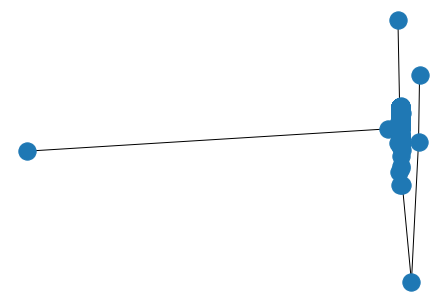

In [74]:
# Construct a MST only using the 750 points modified above
(graph_centerline, pointsCor3D_centerline) = getMSTFromDataPoint(points_centerline, drawMST=True, sampleNumber=5000)  

# constantly delete the node that only has one edge, until there are only two nodes only having one edge left,
# both of them are the endpoints of one singal path representing the colon

toRemove = []
removeCount = 0
removedNodeDict = defaultdict(list)

print("MST has", len(pointsCor3D_centerline), "nodes. Now begin to trim the graph.")

while (True):
    toRemove = []
    for node in graph_centerline.nodes():
        if(len(graph_centerline.edges(node)) == 1):
            removedNodeDict[list(graph_centerline.edges(node))[0][1]].append(node)
            toRemove.append(node)
    if(len(toRemove) == 2):
        break
    for node in toRemove:
        graph_centerline.remove_node(node)
        removeCount += 1
        toRemove = []
        
        
endpoints = toRemove
print("Done! Trimed", removeCount, "nodes. Now MST has", len(graph_centerline.nodes), "nodes left.")

print("Now begin reconstruct endpoints")
# now add back the nodes that got deleted during the triming
addBackChildren(endpoints[0], 0)
addBackChildren(endpoints[1], 0)

print("Done! Now MST has", len(graph_centerline.nodes), "nodes left.")

# Displat the points on the centerline

to_display = []
for node in graph_centerline.nodes:
    to_display.append(pointsCor3D_centerline[node])
displayPoints(to_display, 1.3)

# check if there is more than 2 endpoints
new_endpoints = []
for node in graph_centerline.nodes:
    if(len(graph_centerline.edges(node)) == 1):
       new_endpoints.append(node)
if(len(new_endpoints) != 2):
    print("Fatal error: multiple endpoints detected!")

# check if there is more than 2 path
path = list(nx.all_simple_paths(graph_centerline, source=new_endpoints[0], target=new_endpoints[1]))
if(len(path) != 1):
    print("Fatal error: multiple path detected!")
    
pointsInorder = path[0]

In [76]:
pointsCorInorder = []
for point in pointsInorder:
    pointsCorInorder.append(pointsCor3D_centerline[point])
np.savetxt("centerline.csv", pointsCorInorder, delimiter=" ")
np.save("testInOrder", pointsCorInorder)

In [ ]:
np.savetxt("centerline.csv", pointsCorInorder, delimiter=",")

In [ ]:
displayPoints(np.load("centerlineInorder.npy"), 1.3)

In [ ]:
c = curve()
for pointIndex in pointsInorder:
    c.append(pointCorToVector(pointsCor3D_centerline[pointIndex]))

In [ ]:
toDisplay=[]
for node in graph_centerline.nodes():
    toDisplay.append(pointsCor3D_centerline[node])
displayPoints(toDisplay, 1.3)